In [1]:
from os import listdir
import os, random, copy
from PIL import Image
import numpy as np
from collections import defaultdict
import pandas as pd

In [2]:
def load_data(data_dir="./aligned/"):
	""" Load all PNG images stored in your data directory into a list of NumPy
	arrays.

	Args:
		data_dir: The relative directory path to the CK+ image directory.
	Returns:
		images: A dictionary with keys as emotions and a list containing images associated with each key.
		cnt: A dictionary that stores the # of images in each emotion
	"""
	images = defaultdict(list)

	# Get the list of emotional directory:
	for e in listdir(data_dir):
		# excluding any non-directory files
		if not os.path.isdir(os.path.join(data_dir, e)):
			continue
		# Get the list of image file names
		all_files = listdir(os.path.join(data_dir, e))

		for file in all_files:
			# Load only image files as PIL images and convert to NumPy arrays
			if '.png' in file:
				img = Image.open(os.path.join(data_dir, e, file))
				images[e].append(np.array(img))

	print("Emotions: {} \n".format(list(images.keys())))

	cnt = defaultdict(int)
	for e in images.keys():
		print("{}: {} # of images".format(e, len(images[e])))
		cnt[e] = len(images[e])
	return images, cnt

def balanced_sampler(dataset, cnt, emotions):
	# this ensures everyone has the same balanced subset for model training, don't change this seed value
	random.seed(20)
	print("\nBalanced Set:")
	min_cnt = min([cnt[e] for e in emotions])
	balanced_subset = defaultdict(list)
	for e in emotions:
		balanced_subset[e] = copy.deepcopy(dataset[e])
		random.shuffle(balanced_subset[e])
		balanced_subset[e] = balanced_subset[e][:min_cnt]
		print('{}: {} # of images'.format(e, len(balanced_subset[e])))
	return balanced_subset

def display_face(img):
	""" Display the input image and optionally save as a PNG.

	Args:
		img: The NumPy array or image to display

	Returns: None
	"""
	# Convert img to PIL Image object (if it's an ndarray)
	if type(img) == np.ndarray:
		print("Converting from array to PIL Image")
		img = Image.fromarray(img)

	# Display the image
	img.show()

In [3]:
# example on how to use it
if __name__ == '__main__':
	# The relative path to your image directory
	data_dir = "./PA1/aligned/"
	dataset, cnt = load_data(data_dir)
	# test with happiness and anger
	images = balanced_sampler(dataset, cnt, emotions=['fear', 'surprise', 'sadness', 'happiness', 'anger', 'disgust'] )
	display_index = 0
	display_face(images['anger'][display_index])

Emotions: ['fear', 'surprise', 'sadness', 'happiness', 'anger', 'disgust'] 

fear: 25 # of images
surprise: 83 # of images
sadness: 28 # of images
happiness: 69 # of images
anger: 45 # of images
disgust: 59 # of images

Balanced Set:
fear: 25 # of images
surprise: 25 # of images
sadness: 25 # of images
happiness: 25 # of images
anger: 25 # of images
disgust: 25 # of images
Converting from array to PIL Image


In [4]:
def create_set(dataset,percent1,percent2):
    train_lst=[]
    label_lst=[]
    train=[v[int(percent1*len(v)):int(percent2*len(v))] for k,v in dataset.items()]
    labels=[k for k,v in dataset.items()]
    for i in range(len(train)):
        for j in train[i]:
            train_lst.append(j)
            label_lst.append(labels[i])
    return(train_lst,label_lst)

In [5]:
#get image categories
images.keys()

dict_keys(['fear', 'surprise', 'sadness', 'happiness', 'anger', 'disgust'])

In [6]:
#map categories to numeric categories
d = dict([(y,x) for x,y in enumerate(sorted(set(images.keys())))])

In [7]:
#one-hot encoding of y target
def one_hot(y):
    y=np.array(y)
    y_ = np.zeros((y.size, y.max()+1))
    y_[np.arange(y.size),y] = 1
    return(y_)

In [8]:
def input_gd(dataset):
    [np.random.shuffle(v) for k,v in dataset.items()]#random shuffle images
    
    #create sets
    train_x=create_set(dataset,0,0.8)[0]
    train_y=create_set(dataset,0,0.8)[1]
    test_x=create_set(dataset,0.8,0.9)[0]
    test_y=create_set(dataset,0.8,0.9)[1]
    valid_x=create_set(dataset,0.9,1)[0]
    valid_y=create_set(dataset,0.9,1)[1]
    
    #flatten feature vectors
    train_x_=np.array([x.flatten() for x in train_x])
    test_x_=np.array([x.flatten() for x in test_x])
    valid_x_=np.array([x.flatten() for x in valid_x])
    
    #insert bias term
    train_x_=np.array([np.insert(x,0,1) for x in train_x_])
    test_x_=np.array([np.insert(x,0,1) for x in test_x_])
    valid_x_=np.array([np.insert(x,0,1) for x in valid_x_])
    
    #one hot encode y
    train_y_=one_hot([d[str(x)] for x in train_y])
    test_y_=one_hot([d[str(x)] for x in test_y])
    valid_y_=one_hot([d[str(x)] for x in valid_y])
    
    return(train_x_,train_y_, test_x_,test_y_,valid_x_, valid_y_)

## Batch Gradient Descent

In [9]:
#define number of inputs and outputs
num_inputs=224*192
num_outputs=6

In [10]:
#make weights and bias arrays
W = np.zeros((num_inputs+1, num_outputs))

In [11]:
#define net input of matrix which is dot product of feature matrix and weights
def net_input(X, W):
    return (X.dot(W))

In [12]:
#define softmax function
def softmax(z):
    return (np.exp(z.T) / np.sum(np.exp(z), axis=1)).T

In [13]:
#define functions to convert to class labels
def to_classlabel(z):
    return z.argmax(axis=1)

In [14]:
def cross_entropy(output, y_target):
    return - np.sum(np.log(output) * (y_target),axis=1)

In [15]:
def cost(output, y_target):
    return np.sum(cross_entropy(output, y_target))

In [16]:
def ComputeSigmoidFunction(func):
    if type(func) is np.ndarray:
        func = func[0]
    return 1/(1 + np.exp(-1 * func))

In [17]:
def class_gradient(x,y,w,c):
    gradient = [0]*(len(w[c])) #create gradient array
    for i in range(len(x)): #iterate over all samples
        inter=ComputeSigmoidFunction(np.dot(x[i],w[c]))
        for j in range(len(x[i])):
            gradient[j] += (y[i][c] - inter)*x[i][j]
    return np.array(gradient).reshape(len(gradient), 1)
        
        

In [18]:
new=input_gd(images)

In [19]:
epoch=[]
train_loss=[]
valid_loss=[]

for y in range(50): #number of epochs
    new=input_gd(images)
    train_x_=new[0]
    train_y_=new[1]
    valid_x_=new[4]
    valid_y_=new[5]
    adj_weight=class_gradient(train_x_,train_y_, W.T,0)
    for x in range(1,len(W.T)):
        adj_weight=np.column_stack((adj_weight, class_gradient(train_x_,train_y_, W.T,x)))
    learningRate = 10**-10
    W=W+(learningRate*adj_weight)
    epoch.append(y)
    train_loss.append(cost(softmax(net_input(train_x_,W)),train_y_)/(len(train_x_)*num_outputs))
    valid_loss.append(cost(softmax(net_input(valid_x_,W)),valid_y_)/(len(valid_x_)*num_outputs))
    

In [20]:
df=pd.DataFrame({"epoch":epoch,"train_loss":train_loss, "valid_loss":valid_loss})
df.head()

,epoch,train_loss,valid_loss
0,0,0.295233,0.295818
1,1,0.292962,0.294770
2,2,0.288916,0.290731
3,3,0.286379,0.286889
4,4,0.282777,0.286584


In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

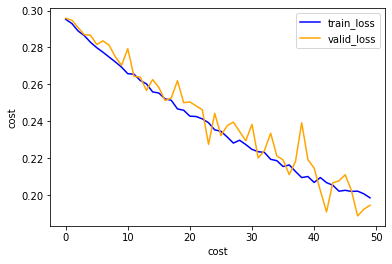

In [22]:
plt.plot( 'epoch', 'train_loss', data=df, marker='', color="blue")
plt.plot( 'epoch', 'valid_loss', data=df, marker='', color="orange")
plt.ylabel("cost")
plt.xlabel("cost")
plt.legend()

In [23]:
test_x_=new[2]
test_y_=new[3]

In [24]:
y_pred=pd.Series(to_classlabel(softmax(net_input(test_x_,W))),name="Predicted")

In [25]:
y_act=pd.Series(to_classlabel(test_y_),name="Actual")

In [26]:
df_conf=pd.crosstab(y_act,y_pred)

In [27]:
labels=[x for x in d.keys()]

In [28]:
y_act

0     2
1     2
2     5
3     5
4     4
5     4
6     3
7     3
8     0
9     0
10    1
11    1
Name: Actual, dtype: int64

In [29]:
df_conf_=df_conf/num_outputs

In [30]:
df_conf_.columns=labels

In [31]:
df_conf_.index=labels

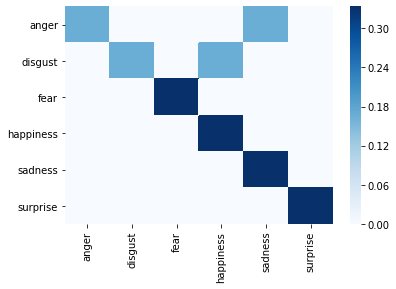

In [32]:
import seaborn as sns
sns.heatmap(df_conf_,cmap="Blues")

In [33]:
avg_epoch=[]
train_loss_mean=[]
train_loss_std=[]
valid_loss_mean=[]
valid_loss_std=[]

for i in range(5):
    df_filt=df[10*i:10*(i+1)]
    avg_epoch.append(10*(i+1))
    train_loss_mean.append(np.mean(df_filt["train_loss"]))
    train_loss_std.append(np.std(df_filt["train_loss"]))
    valid_loss_mean.append(np.mean(df_filt["valid_loss"]))
    valid_loss_std.append(np.std(df_filt["valid_loss"]))

In [34]:
df2=pd.DataFrame({"avg_epoch":avg_epoch,"train_loss_mean":train_loss_mean,
                  "train_loss_std":train_loss_std,"valid_loss_mean":valid_loss_mean, "valid_loss_std":valid_loss_std})

In [35]:
df2

,avg_epoch,train_loss_mean,train_loss_std,valid_loss_mean,valid_loss_std
0,10,0.281972,0.008366,0.284629,0.007729
1,20,0.256072,0.006833,0.260077,0.008141
2,30,0.235198,0.005656,0.238966,0.007695
3,40,0.217286,0.005218,0.224346,0.008928
4,50,0.203569,0.003177,0.201065,0.008598


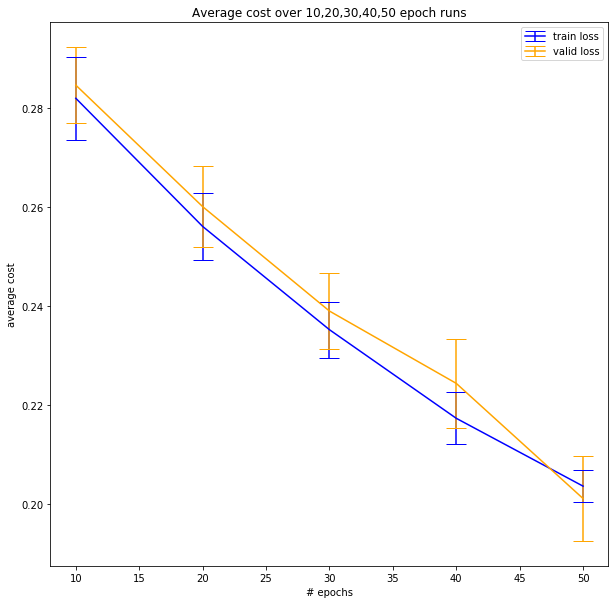

In [36]:
plt.figure(figsize=(10,10))
plt.errorbar( df2['avg_epoch'].tolist(), df2['train_loss_mean'].tolist(), 
             yerr=df2["train_loss_std"].tolist(), capsize=10, color="blue",label="train loss")
plt.errorbar( df2['avg_epoch'].tolist(), df2['valid_loss_mean'].tolist(), 
             yerr=df2["valid_loss_std"].tolist(), capsize=10, color="orange",label="valid loss")
plt.xlabel("# epochs")
plt.ylabel("average cost")
plt.title("Average cost over 10,20,30,40,50 epoch runs")
plt.legend()

## Stochastic Gradient Descent

In [37]:
#make weights and bias arrays
W = np.zeros((num_inputs+1, num_outputs))

In [38]:
def stochastic_class_gradient(x,y,w,i):
    #create starting vector
    weight_update = [0]*(len(w[0]))
    inter=ComputeSigmoidFunction(np.dot(x[i],w[0]))
    for j in range(len(x[i])):
        weight_update[j] += (y[i][0] - inter)*x[i][j]
    
    for c in range(1,len(w)):
        gradient = [0]*(len(w[c])) #create gradient array
        inter=ComputeSigmoidFunction(np.dot(x[i],w[c]))
        for j in range(len(x[i])):
            gradient[j] += (y[i][c] - inter)*x[i][j]
        add=np.array(gradient).reshape(len(gradient), 1)
        weight_update=np.column_stack((weight_update,add))
    return weight_update

In [39]:
stoch_epoch=[]
stoch_training_loss=[]
for e in range(50):
    for itera in range(0,len(train_x_)):
        learningRate = 10**-10
        W=W+(learningRate*stochastic_class_gradient(train_x_,train_y_,W.T,itera))
    stoch_epoch.append(e)
    stoch_training_loss.append(cost(softmax(net_input(train_x_,W)),train_y_)/(len(train_x_)*num_outputs))

In [42]:
df3=pd.DataFrame({"epoch":stoch_epoch,"batch":train_loss,"stochastic":stoch_training_loss})

In [43]:
df3.head()

,epoch,batch,stochastic
0,0,0.295233,0.307851
1,1,0.292962,0.308308
2,2,0.288916,0.306110
3,3,0.286379,0.303300
4,4,0.282777,0.300358


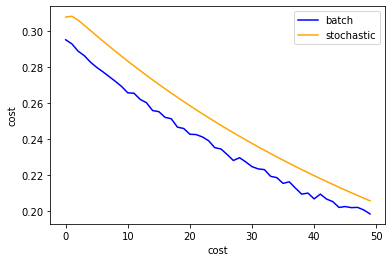

In [44]:
plt.plot( 'epoch', 'batch', data=df3, marker='', color="blue")
plt.plot( 'epoch', 'stochastic', data=df3, marker='', color="orange")
plt.ylabel("cost")
plt.xlabel("cost")
plt.legend()